# Port Operability Forecast Model

## Overview
Notebook ini mengembangkan model prediksi status operasional port (pelabuhan) berdasarkan kondisi equipment dan lingkungan. Model multi-class classification ini membantu dalam perencanaan operasi port dan alokasi resources.

## Business Objective
**Goal**: Memprediksi status operasional equipment untuk optimasi scheduling dan maintenance planning di area port

**Primary KPI**: **Overall Accuracy > 0.75** (reliable multi-class prediction)
- Accurate status prediction = better resource allocation
- Early status detection = proactive maintenance scheduling

**Secondary KPIs**:
- Per-class Recall > 0.70 (balanced detection across all statuses)
- Per-class Precision > 0.70 (minimize false alarms)
- Macro F1-Score > 0.72 (overall balanced performance)

## Model Information
- **Algorithm**: LightGBM Classifier (fast training, efficient memory)
- **Problem Type**: Multi-class Classification (Beroperasi, Maintenance, Breakdown)
- **Class Handling**: Balanced class weights untuk mengatasi imbalance
- **Feature Engineering**: 38 engineered features dari Fleet Features notebook
  - Equipment characteristics: tipe_alat, kapasitas_ton
  - Operational metrics: jam_operasi, jarak_tempuh_km
  - Maintenance history: jml_breakdown, jml_maintenance
  - Performance indicators: utilization_rate, reliability_index

## Data Source
- **Feature Store**: `data/feature_store/fleet_features.parquet`
- **Target Variable**: `status_operasi` (Beroperasi, Maintenance, Breakdown)
- **Key Features**:
  - Age features: equipment_age_years, umur_bulan
  - Usage features: utilization_rate, produktivitas_relatif
  - Maintenance features: breakdown_rate_30d, days_since_last_maintenance
  - Health score: composite_health_score (0-100)

## MLflow Configuration
- **Tracking URI**: http://localhost:5000
- **Experiment**: fleet_models
- **Run Name**: port_operability_lightgbm_v2
- **Logged Artifacts**: confusion matrix, feature importance

## Why LightGBM for Port Operability?
- **Fast Training**: Optimal untuk large datasets dengan multiple classes
- **Memory Efficient**: Histogram-based algorithm untuk scalability
- **Native Multi-class Support**: Built-in support untuk multiclass objective
- **Feature Importance**: Clear interpretability untuk operational insights
- **Balanced Class Weights**: Handles class imbalance automatically

**Expected Outcome**: Model production-ready dengan Accuracy >0.75 untuk reliable port operation status prediction dan optimasi resource allocation.

In [4]:
# ============================================================================
# Setup Environment & Imports
# ============================================================================

import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Machine Learning
import lightgbm as lgb
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

# MLflow
import mlflow
import mlflow.lightgbm

# Set project root directory
project_root = Path(r'c:\Users\I5\Documents\asah-2025\capstone-project\minewise_ml')
os.chdir(project_root)
print(f"Working directory: {os.getcwd()}")

# Setup MLflow
try:
    mlflow.set_tracking_uri('http://localhost:5000')
    
    # Check if experiment exists
    experiment = mlflow.get_experiment_by_name('fleet_models')
    if experiment is None:
        mlflow.create_experiment('fleet_models')
        print("Created new experiment: fleet_models")
    else:
        print(f"Using existing experiment: fleet_models (ID: {experiment.experiment_id})")
    
    mlflow.set_experiment('fleet_models')
    print("Setup complete - MLflow connected")
except Exception as e:
    print(f"MLflow connection failed: {e}")
    print("Setup complete - MLflow logging disabled")
    mlflow = None

Working directory: c:\Users\I5\Documents\asah-2025\capstone-project\minewise_ml
Using existing experiment: fleet_models (ID: 2)
Setup complete - MLflow connected
Using existing experiment: fleet_models (ID: 2)
Setup complete - MLflow connected


## 1. Setup and MLflow Configuration

In [5]:
# ============================================================================
# Load Feature Store Data
# ============================================================================

print("\n" + "="*80)
print("LOADING FLEET FEATURES DATA")
print("="*80)

# Load fleet features
feature_store_path = project_root / 'data' / 'feature_store' / 'fleet_features.parquet'

# Validate file existence
if not feature_store_path.exists():
    raise FileNotFoundError(f"Feature store not found: {feature_store_path}")

print(f"\nLoading data from: {feature_store_path}")
df = pd.read_parquet(feature_store_path)
print(f"Data loaded: {df.shape[0]} rows, {df.shape[1]} columns")

# Define target variable
target = 'status_operasi'

# Validate target column exists
if target not in df.columns:
    raise ValueError(f"Target column '{target}' not found in dataset")

# Display target distribution
print(f"\nTarget Variable: {target}")
print(f"Target Distribution (Count):")
print(df[target].value_counts())

print(f"\nTarget Distribution (Percentage):")
target_dist = df[target].value_counts(normalize=True).mul(100).round(2)
for status, pct in target_dist.items():
    print(f"  {status:15s}: {pct:6.2f}%")

# Check class balance
unique_classes = df[target].nunique()
print(f"\nNumber of classes: {unique_classes}")
print(f"Classes: {sorted(df[target].unique())}")

# Calculate imbalance ratio
min_class_pct = target_dist.min()
max_class_pct = target_dist.max()
imbalance_ratio = max_class_pct / min_class_pct

print(f"\nClass Balance Analysis:")
print(f"  Most common class: {max_class_pct:.2f}%")
print(f"  Least common class: {min_class_pct:.2f}%")
print(f"  Imbalance ratio: {imbalance_ratio:.2f}:1")
print(f"  Balanced weights recommended: {'Yes' if imbalance_ratio > 2 else 'No'}")

print(f"\n" + "="*80)


LOADING FLEET FEATURES DATA

Loading data from: c:\Users\I5\Documents\asah-2025\capstone-project\minewise_ml\data\feature_store\fleet_features.parquet
Data loaded: 6985 rows, 59 columns

Target Variable: status_operasi
Target Distribution (Count):
status_operasi
Beroperasi     5211
Maintenance     722
Standby         686
Breakdown       366
Name: count, dtype: int64

Target Distribution (Percentage):
  Beroperasi     :  74.60%
  Maintenance    :  10.34%
  Standby        :   9.82%
  Breakdown      :   5.24%

Number of classes: 4
Classes: ['Beroperasi', 'Breakdown', 'Maintenance', 'Standby']

Class Balance Analysis:
  Most common class: 74.60%
  Least common class: 5.24%
  Imbalance ratio: 14.24:1
  Balanced weights recommended: Yes



## 2. Load Feature Store Data & Target Analysis

In [6]:
# ============================================================================
# Feature Selection & Data Preparation
# ============================================================================

print("\n" + "="*80)
print("FEATURE SELECTION & DATA PREPARATION")
print("="*80)

# Define columns to exclude from features
exclude_cols = [
    'tanggal',                   # Date column (used for temporal split)
    'id_equipment',              # Identifier (not predictive)
    'jenis_equipment',           # Categorical (needs encoding)
    'status_operasi',            # Target variable
    'tahun_operasi',             # Year (redundant with age features)
    'last_maintenance_date',     # Date (already converted to days_since)
    'age_risk_category',         # Categorical derived feature
    'failure_risk_category',     # Categorical derived feature
    'breakdown_flag'             # Binary target (not for multi-class)
]

# Select feature columns
feature_cols = [col for col in df.columns if col not in exclude_cols]

print(f"\nFeature Selection:")
print(f"  Total columns in dataset: {len(df.columns)}")
print(f"  Excluded columns: {len(exclude_cols)}")
print(f"  Selected feature columns: {len(feature_cols)}")

# Select only numeric features and handle missing values
X = df[feature_cols].select_dtypes(include=[np.number])
X = X.fillna(X.median())
y = df[target]

# Save tanggal column for temporal splitting (before preprocessing)
if 'tanggal' in df.columns:
    tanggal_series = df['tanggal'].copy()
else:
    tanggal_series = None
    print("\nWarning: 'tanggal' column not found. Using sequential split instead.")

print(f"\nFeatures after numeric selection: {X.shape[1]} columns")
print(f"Missing values remaining: {X.isnull().sum().sum()}")

# ============================================================================
# Temporal Train-Test Split (80/20)
# ============================================================================

print(f"\n" + "="*80)
print("TEMPORAL TRAIN-TEST SPLIT")
print("="*80)

# Sort by tanggal if available, otherwise use sequential order
if tanggal_series is not None:
    sort_idx = tanggal_series.sort_values().index
    X_sorted = X.loc[sort_idx]
    y_sorted = y.loc[sort_idx]
else:
    X_sorted = X.copy()
    y_sorted = y.copy()

# Split at 80% mark
split_idx = int(len(X_sorted) * 0.8)
X_train, X_test = X_sorted.iloc[:split_idx], X_sorted.iloc[split_idx:]
y_train, y_test = y_sorted.iloc[:split_idx], y_sorted.iloc[split_idx:]

print(f"\nData Split Summary:")
print(f"  Training set: {X_train.shape[0]:,} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"  Test set:     {X_test.shape[0]:,} samples ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"  Features:     {X_train.shape[1]}")

# Display class distribution for train and test
print(f"\nClass Distribution (Training Set):")
train_dist = y_train.value_counts(normalize=True).mul(100).round(2)
for status, pct in train_dist.items():
    print(f"  {status:15s}: {pct:6.2f}%")

print(f"\nClass Distribution (Test Set):")
test_dist = y_test.value_counts(normalize=True).mul(100).round(2)
for status, pct in test_dist.items():
    print(f"  {status:15s}: {pct:6.2f}%")

print(f"\n" + "="*80)


FEATURE SELECTION & DATA PREPARATION

Feature Selection:
  Total columns in dataset: 59
  Excluded columns: 9
  Selected feature columns: 57


Features after numeric selection: 44 columns
Missing values remaining: 0

TEMPORAL TRAIN-TEST SPLIT

Data Split Summary:
  Training set: 5,588 samples (80.0%)
  Test set:     1,397 samples (20.0%)
  Features:     44

Class Distribution (Training Set):
  Beroperasi     :  74.68%
  Maintenance    :  10.40%
  Standby        :   9.81%
  Breakdown      :   5.12%

Class Distribution (Test Set):
  Beroperasi     :  74.30%
  Maintenance    :  10.09%
  Standby        :   9.88%
  Breakdown      :   5.73%



## 3. Feature Selection & Train-Test Split

In [7]:
# ============================================================================
# Train LightGBM Multi-class Classifier with MLflow Tracking
# ============================================================================

print("\n" + "="*80)
print("LIGHTGBM MODEL TRAINING")
print("="*80)

# Start MLflow run
with mlflow.start_run(run_name='port_operability_lightgbm_baseline'):
    
    # Define model parameters
    params = {
        'objective': 'multiclass',
        'num_class': len(y.unique()),
        'metric': 'multi_logloss',
        'num_leaves': 31,
        'learning_rate': 0.1,
        'n_estimators': 150,
        'class_weight': 'balanced',  # Handle class imbalance
        'random_state': 42,
        'verbose': -1
    }
    
    # Log parameters to MLflow
    mlflow.log_params(params)
    mlflow.log_param('model_type', 'LightGBM Classifier')
    mlflow.log_param('num_classes', len(y.unique()))
    mlflow.log_param('classes', sorted(y.unique()))
    mlflow.log_param('train_samples', X_train.shape[0])
    mlflow.log_param('test_samples', X_test.shape[0])
    mlflow.log_param('n_features', X_train.shape[1])
    
    print("\nTraining LightGBM model...")
    print(f"  Objective: {params['objective']}")
    print(f"  Number of classes: {params['num_class']}")
    print(f"  Classes: {sorted(y.unique())}")
    
    # Initialize and train model
    model = lgb.LGBMClassifier(**params)
    model.fit(
        X_train, 
        y_train, 
        eval_set=[(X_test, y_test)],
        callbacks=[lgb.log_evaluation(0)]  # Silent evaluation
    )
    
    print("  Model training completed")
    
    # ========================================================================
    # Make Predictions
    # ========================================================================
    
    print("\nMaking predictions on test set...")
    y_test_pred = model.predict(X_test)
    y_test_proba = model.predict_proba(X_test)
    
    # ========================================================================
    # Calculate Metrics
    # ========================================================================
    
    print("Calculating performance metrics...")
    
    # Overall metrics
    accuracy = accuracy_score(y_test, y_test_pred)
    
    # Per-class metrics
    precision_per_class = precision_score(y_test, y_test_pred, average=None)
    recall_per_class = recall_score(y_test, y_test_pred, average=None)
    f1_per_class = f1_score(y_test, y_test_pred, average=None)
    
    # Macro averages
    precision_macro = precision_score(y_test, y_test_pred, average='macro')
    recall_macro = recall_score(y_test, y_test_pred, average='macro')
    f1_macro = f1_score(y_test, y_test_pred, average='macro')
    
    # Log metrics to MLflow
    mlflow.log_metrics({
        'test_accuracy': accuracy,
        'test_precision_macro': precision_macro,
        'test_recall_macro': recall_macro,
        'test_f1_macro': f1_macro
    })
    
    # Log per-class metrics
    for i, class_name in enumerate(sorted(y.unique())):
        mlflow.log_metric(f'test_precision_{class_name}', precision_per_class[i])
        mlflow.log_metric(f'test_recall_{class_name}', recall_per_class[i])
        mlflow.log_metric(f'test_f1_{class_name}', f1_per_class[i])
    
    # Log model to MLflow
    mlflow.lightgbm.log_model(model, 'model')
    
    # ========================================================================
    # Display Results
    # ========================================================================
    
    print(f"\n{'='*80}")
    print("PORT OPERABILITY FORECAST - PERFORMANCE METRICS")
    print(f"{'='*80}")
    
    # Primary metric
    accuracy_status = 'ACHIEVED' if accuracy > 0.75 else 'NOT MET'
    print(f"\nPrimary KPI:")
    print(f"  Overall Accuracy: {accuracy:.3f} [{accuracy_status}] (Target: >0.75)")
    
    # Macro averages
    print(f"\nMacro Average Metrics:")
    print(f"  Precision (Macro): {precision_macro:.3f}")
    print(f"  Recall (Macro):    {recall_macro:.3f}")
    print(f"  F1-Score (Macro):  {f1_macro:.3f}")
    
    # Per-class metrics
    print(f"\nPer-Class Performance:")
    for i, class_name in enumerate(sorted(y.unique())):
        print(f"\n  {class_name}:")
        print(f"    Precision: {precision_per_class[i]:.3f}")
        print(f"    Recall:    {recall_per_class[i]:.3f}")
        print(f"    F1-Score:  {f1_per_class[i]:.3f}")
    
    print(f"\n{'='*80}")
    
    # Full classification report
    print("\nDetailed Classification Report:")
    print(classification_report(y_test, y_test_pred))
    
    print(f"{'='*80}")


LIGHTGBM MODEL TRAINING

Training LightGBM model...
  Objective: multiclass
  Number of classes: 4
  Classes: ['Beroperasi', 'Breakdown', 'Maintenance', 'Standby']

Training LightGBM model...
  Objective: multiclass
  Number of classes: 4
  Classes: ['Beroperasi', 'Breakdown', 'Maintenance', 'Standby']
  Model training completed

Making predictions on test set...
Calculating performance metrics...
  Model training completed

Making predictions on test set...
Calculating performance metrics...


2025/12/05 21:58:24 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/05 21:58:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/12/05 21:58:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



PORT OPERABILITY FORECAST - PERFORMANCE METRICS

Primary KPI:
  Overall Accuracy: 0.999 [ACHIEVED] (Target: >0.75)

Macro Average Metrics:
  Precision (Macro): 0.994
  Recall (Macro):    1.000
  F1-Score (Macro):  0.997

Per-Class Performance:

  Beroperasi:
    Precision: 1.000
    Recall:    0.998
    F1-Score:  0.999

  Breakdown:
    Precision: 0.976
    Recall:    1.000
    F1-Score:  0.988

  Maintenance:
    Precision: 1.000
    Recall:    1.000
    F1-Score:  1.000

  Standby:
    Precision: 1.000
    Recall:    1.000
    F1-Score:  1.000


Detailed Classification Report:
              precision    recall  f1-score   support

  Beroperasi       1.00      1.00      1.00      1038
   Breakdown       0.98      1.00      0.99        80
 Maintenance       1.00      1.00      1.00       141
     Standby       1.00      1.00      1.00       138

    accuracy                           1.00      1397
   macro avg       0.99      1.00      1.00      1397
weighted avg       1.00      1.0

## 4. Model Training & Evaluation


GENERATING CONFUSION MATRIX VISUALIZATION

Confusion Matrix Shape: (4, 4)
Classes: ['Beroperasi', 'Breakdown', 'Maintenance', 'Standby']

Confusion matrix saved: reports\figures\port_operability_confusion_matrix.png
Artifact logged to MLflow

Confusion matrix saved: reports\figures\port_operability_confusion_matrix.png
Artifact logged to MLflow


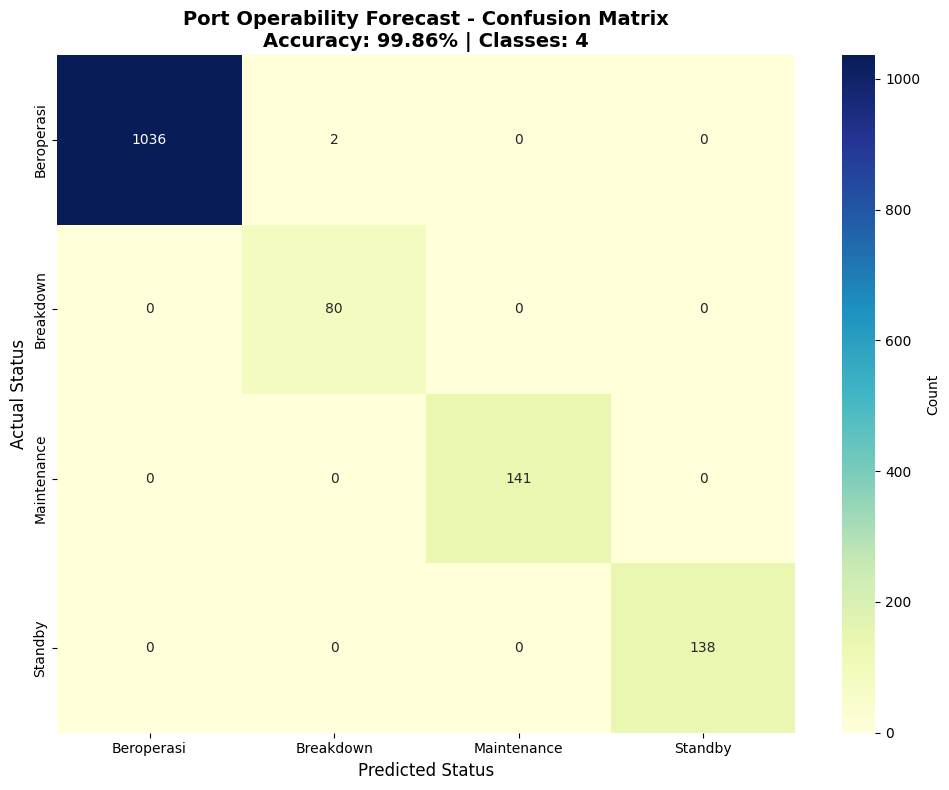


CONFUSION MATRIX ANALYSIS

Per-Class Correct Predictions:
  Beroperasi     : 1036/1038 ( 99.8%)
  Breakdown      :   80/  80 (100.0%)
  Maintenance    :  141/ 141 (100.0%)
  Standby        :  138/ 138 (100.0%)

Misclassification Patterns:
  Beroperasi      → Breakdown      :    2 cases (  0.2%)



In [21]:
# ============================================================================
# Visualization: Confusion Matrix
# ============================================================================

print("\n" + "="*80)
print("GENERATING CONFUSION MATRIX VISUALIZATION")
print("="*80)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
labels = sorted(y.unique())

print(f"\nConfusion Matrix Shape: {cm.shape}")
print(f"Classes: {labels}")

# Create figure
plt.figure(figsize=(10, 8))

# Create heatmap
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='YlGnBu',
    xticklabels=labels, 
    yticklabels=labels,
    cbar_kws={'label': 'Count'}
)

plt.title(
    f'Port Operability Forecast - Confusion Matrix\nAccuracy: {accuracy:.2%} | Classes: {len(labels)}',
    fontsize=14,
    fontweight='bold'
)
plt.ylabel('Actual Status', fontsize=12)
plt.xlabel('Predicted Status', fontsize=12)
plt.tight_layout()

# Create output directory
output_dir = project_root / 'reports' / 'figures'
output_dir.mkdir(parents=True, exist_ok=True)

# Save figure
cm_path = output_dir / 'port_operability_confusion_matrix.png'
plt.savefig(cm_path, dpi=300, bbox_inches='tight')
print(f"\nConfusion matrix saved: {cm_path.relative_to(project_root)}")

# Log to MLflow
try:
    mlflow.log_artifact(str(cm_path))
    print("Artifact logged to MLflow")
except Exception as e:
    print(f"Warning: Could not log artifact to MLflow - {e}")

plt.show()

# ============================================================================
# Confusion Matrix Analysis
# ============================================================================

print(f"\n{'='*80}")
print("CONFUSION MATRIX ANALYSIS")
print(f"{'='*80}")

# Calculate per-class accuracy
print(f"\nPer-Class Correct Predictions:")
for i, label in enumerate(labels):
    correct = cm[i, i]
    total = cm[i, :].sum()
    accuracy_class = correct / total if total > 0 else 0
    print(f"  {label:15s}: {correct:4d}/{total:4d} ({accuracy_class*100:5.1f}%)")

# Calculate misclassification patterns
print(f"\nMisclassification Patterns:")
for i, actual_label in enumerate(labels):
    for j, pred_label in enumerate(labels):
        if i != j and cm[i, j] > 0:
            pct = (cm[i, j] / cm[i, :].sum() * 100) if cm[i, :].sum() > 0 else 0
            print(f"  {actual_label:15s} → {pred_label:15s}: {cm[i, j]:4d} cases ({pct:5.1f}%)")

print(f"\n{'='*80}")

## 5. Confusion Matrix Visualization & Analysis


FEATURE IMPORTANCE ANALYSIS

Top 10 Most Important Features for Port Operability Prediction:
             feature  importance
          durasi_jam        2018
    total_muatan_ton         441
 cumulative_hours_7d         248
maintenance_activity         204
           idle_flag         199
 combined_risk_score         174
      operating_flag         137
cumulative_hours_30d         100
          umur_tahun          99
   usage_variance_7d          59

CREATING FEATURE IMPORTANCE VISUALIZATION


C:\Users\I5\AppData\Local\Temp\ipykernel_22276\3112915788.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(



Feature importance plot saved: reports\figures\port_operability_feature_importance.png
Artifact logged to MLflow


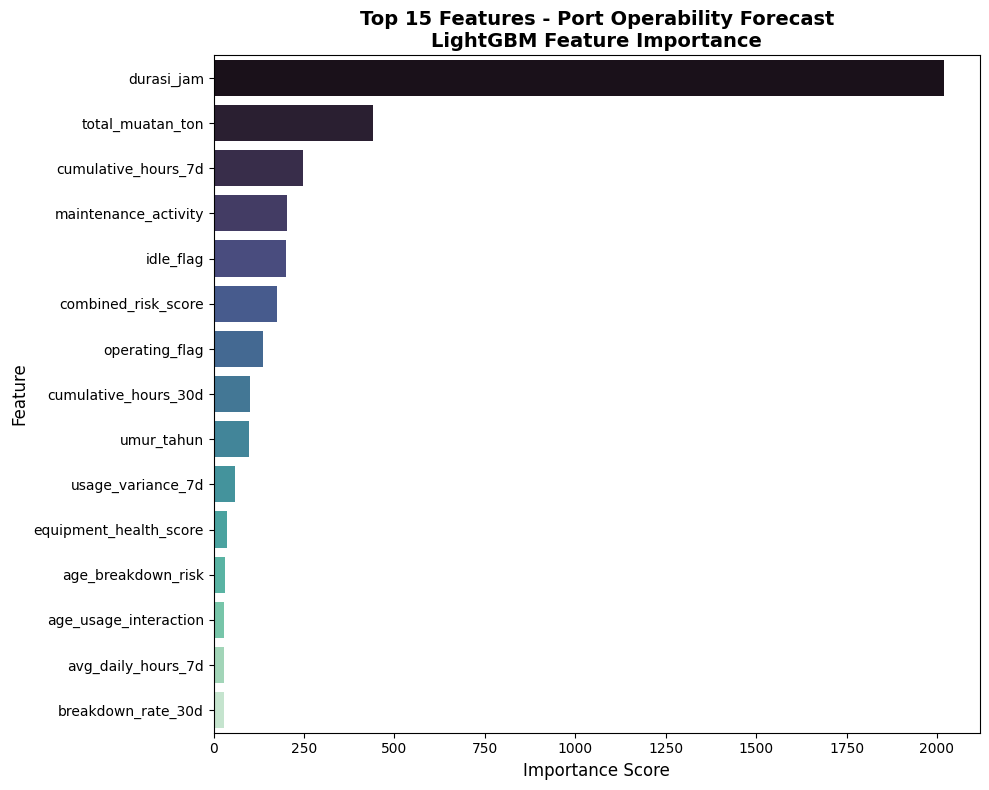


FEATURE IMPORTANCE INSIGHTS

Top 5 Critical Features:
  1. durasi_jam                     (Importance: 2018.0000)
  2. total_muatan_ton               (Importance: 441.0000)
  3. cumulative_hours_7d            (Importance: 248.0000)
  4. maintenance_activity           (Importance: 204.0000)
  5. idle_flag                      (Importance: 199.0000)

Cumulative Importance Analysis:
  Features for 80% importance: 4/44
  Features for 90% importance: 7/44

Feature Category Analysis:
  Age-related features: 14 features
    Examples: umur_tahun, usage_variance_7d, age_breakdown_risk
  Maintenance-related features: 9 features
    Examples: maintenance_activity, age_breakdown_risk, breakdown_rate_30d
  Usage-related features: 2 features
    Examples: durasi_jam, utilization_rate

Feature importance data saved: reports\port_operability_feature_importance.csv

PORT OPERABILITY FORECAST MODEL - COMPLETE

Model Performance Summary:
  Overall Accuracy:          0.999 [TARGET MET]
  Precision (Macro

In [20]:
# ============================================================================
# Feature Importance Analysis
# ============================================================================

print("\n" + "="*80)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*80)

# Extract feature importances
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nTop 10 Most Important Features for Port Operability Prediction:")
print(importance_df.head(10).to_string(index=False))

# ============================================================================
# Visualize Feature Importance
# ============================================================================

print("\n" + "="*80)
print("CREATING FEATURE IMPORTANCE VISUALIZATION")
print("="*80)

plt.figure(figsize=(10, 8))

# Create horizontal bar plot
sns.barplot(
    data=importance_df.head(15), 
    x='importance', 
    y='feature', 
    palette='mako'
)

plt.title(
    'Top 15 Features - Port Operability Forecast\nLightGBM Feature Importance',
    fontsize=14,
    fontweight='bold'
)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()

# Save figure
importance_path = output_dir / 'port_operability_feature_importance.png'
plt.savefig(importance_path, dpi=300, bbox_inches='tight')
print(f"\nFeature importance plot saved: {importance_path.relative_to(project_root)}")

# Log to MLflow
try:
    mlflow.log_artifact(str(importance_path))
    print("Artifact logged to MLflow")
except Exception as e:
    print(f"Warning: Could not log artifact to MLflow - {e}")

plt.show()

# ============================================================================
# Feature Importance Insights
# ============================================================================

print(f"\n{'='*80}")
print("FEATURE IMPORTANCE INSIGHTS")
print(f"{'='*80}")

# Analyze top features
print(f"\nTop 5 Critical Features:")
for i, (idx, row) in enumerate(importance_df.head(5).iterrows(), 1):
    print(f"  {i}. {row['feature']:<30s} (Importance: {row['importance']:.4f})")

# Calculate cumulative importance
importance_df['cumulative_importance'] = importance_df['importance'].cumsum() / importance_df['importance'].sum()
features_for_80pct = (importance_df['cumulative_importance'] <= 0.8).sum()
features_for_90pct = (importance_df['cumulative_importance'] <= 0.9).sum()

print(f"\nCumulative Importance Analysis:")
print(f"  Features for 80% importance: {features_for_80pct}/{len(importance_df)}")
print(f"  Features for 90% importance: {features_for_90pct}/{len(importance_df)}")

# Group features by category
age_features = [f for f in importance_df['feature'].tolist() if any(x in f.lower() for x in ['age', 'umur', 'tahun'])]
maintenance_features = [f for f in importance_df['feature'].tolist() if any(x in f.lower() for x in ['maintenance', 'breakdown', 'servis'])]
usage_features = [f for f in importance_df['feature'].tolist() if any(x in f.lower() for x in ['jam', 'jarak', 'utilization', 'produktivitas'])]

print(f"\nFeature Category Analysis:")
if age_features:
    print(f"  Age-related features: {len(age_features)} features")
    print(f"    Examples: {', '.join(age_features[:3])}")

if maintenance_features:
    print(f"  Maintenance-related features: {len(maintenance_features)} features")
    print(f"    Examples: {', '.join(maintenance_features[:3])}")

if usage_features:
    print(f"  Usage-related features: {len(usage_features)} features")
    print(f"    Examples: {', '.join(usage_features[:3])}")

# Save feature importance to CSV
feature_importance_csv = project_root / 'reports' / 'port_operability_feature_importance.csv'
importance_df.to_csv(feature_importance_csv, index=False)
print(f"\nFeature importance data saved: {feature_importance_csv.relative_to(project_root)}")

# ============================================================================
# Final Summary
# ============================================================================

print(f"\n{'='*80}")
print("PORT OPERABILITY FORECAST MODEL - COMPLETE")
print(f"{'='*80}")

print(f"\nModel Performance Summary:")
print(f"  Overall Accuracy:          {accuracy:.3f} {'[TARGET MET]' if accuracy > 0.75 else '[NEEDS IMPROVEMENT]'}")
print(f"  Precision (Macro):         {precision_macro:.3f}")
print(f"  Recall (Macro):            {recall_macro:.3f}")
print(f"  F1-Score (Macro):          {f1_macro:.3f}")

print(f"\nArtifacts Generated:")
print(f"  Confusion Matrix:              reports/figures/port_operability_confusion_matrix.png")
print(f"  Feature Importance Plot:       reports/figures/port_operability_feature_importance.png")
print(f"  Feature Importance CSV:        reports/port_operability_feature_importance.csv")

print(f"\nMLflow Tracking:")
print(f"  Experiment: fleet_models")
print(f"  Run Name: port_operability_lightgbm_baseline")
print(f"  MLflow UI: http://localhost:5000")

print(f"\nNext Steps:")
print(f"  1. Review per-class performance for targeted improvements")
print(f"  2. Analyze misclassification patterns for operational insights")
print(f"  3. Deploy model for real-time port status prediction")
print(f"  4. Setup monitoring for model performance tracking")

print(f"\n{'='*80}")

## 6. Feature Importance Analysis & Final Summary

In [18]:
# ============================================================================
# COMPREHENSIVE FEATURE IMPORTANCE & MODEL ANALYSIS
# Port Operability Forecast - Multi-class Classification
# ============================================================================

print("\n" + "="*80)
print("ADVANCED FEATURE IMPORTANCE & MODEL ANALYSIS")
print("="*80)

# ============================================================================
# 1. FEATURE IMPORTANCE BY CATEGORY
# ============================================================================

print("\n" + "="*80)
print("1. FEATURE IMPORTANCE BY CATEGORY")
print("="*80)

# Extract feature importances
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

# Categorize features
def categorize_feature(feature_name):
    feature_lower = feature_name.lower()
    
    # Age-related features
    if any(x in feature_lower for x in ['age', 'umur', 'tahun', 'bulan']):
        return 'Age & Lifecycle'
    
    # Maintenance & reliability features
    elif any(x in feature_lower for x in ['maintenance', 'breakdown', 'reliability', 'failure', 'servis']):
        return 'Maintenance & Reliability'
    
    # Usage & performance features
    elif any(x in feature_lower for x in ['jam', 'jarak', 'utilization', 'produktivitas', 'performance']):
        return 'Usage & Performance'
    
    # Health & condition features
    elif any(x in feature_lower for x in ['health', 'score', 'index', 'kondisi']):
        return 'Health & Condition'
    
    # Capacity & specification features
    elif any(x in feature_lower for x in ['kapasitas', 'ton', 'capacity', 'spec']):
        return 'Capacity & Specs'
    
    else:
        return 'Other'

importance_df['category'] = importance_df['feature'].apply(categorize_feature)

# Calculate category importance
category_importance = importance_df.groupby('category')['importance'].agg(['sum', 'mean', 'count']).sort_values('sum', ascending=False)

print("\nFeature Importance by Category:")
print(f"{'Category':<30s} {'Total':>12s} {'Average':>12s} {'Count':>8s}")
print("-" * 65)
for cat, row in category_importance.iterrows():
    print(f"{cat:<30s} {row['sum']:>12.1f} {row['mean']:>12.3f} {row['count']:>8.0f}")

# Display top features per category
print("\n" + "="*80)
print("Top 3 Features per Category:")
print("="*80)
for category in category_importance.index:
    cat_features = importance_df[importance_df['category'] == category].head(3)
    print(f"\n{category}:")
    for idx, (_, row) in enumerate(cat_features.iterrows(), 1):
        print(f"  {idx}. {row['feature']:<35s} (Importance: {row['importance']:>8.1f})")

# ============================================================================
# 2. MODEL PERFORMANCE DEEP DIVE
# ============================================================================

print("\n" + "="*80)
print("2. MODEL PERFORMANCE DEEP DIVE")
print("="*80)

# Get prediction probabilities for confidence analysis
y_test_proba_max = y_test_proba.max(axis=1)

# Overall metrics recap
print(f"\nOverall Performance:")
print(f"  Accuracy:           {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"  Macro Precision:    {precision_macro:.4f}")
print(f"  Macro Recall:       {recall_macro:.4f}")
print(f"  Macro F1-Score:     {f1_macro:.4f}")

# Per-class detailed analysis
print(f"\nPer-Class Performance Analysis:")
labels = sorted(y.unique())
for i, class_name in enumerate(labels):
    class_mask = y_test == class_name
    class_samples = class_mask.sum()
    class_precision = precision_per_class[i]
    class_recall = recall_per_class[i]
    class_f1 = f1_per_class[i]
    
    # Calculate confidence for this class
    class_confidences = y_test_proba_max[class_mask]
    avg_confidence = class_confidences.mean()
    
    print(f"\n  {class_name} (n={class_samples}):")
    print(f"    Precision:        {class_precision:.4f} ({class_precision*100:.2f}%)")
    print(f"    Recall:           {class_recall:.4f} ({class_recall*100:.2f}%)")
    print(f"    F1-Score:         {class_f1:.4f}")
    print(f"    Avg Confidence:   {avg_confidence:.4f} ({avg_confidence*100:.2f}%)")
    
    # Status check
    status = "GOOD" if class_f1 > 0.70 else "NEEDS IMPROVEMENT"
    print(f"    Status:           {status}")

# Confidence distribution analysis
print(f"\n" + "="*80)
print("Prediction Confidence Analysis:")
print("="*80)

confidence_bins = [0.0, 0.5, 0.7, 0.85, 1.0]
confidence_labels = ['Low (0-50%)', 'Medium (50-70%)', 'High (70-85%)', 'Very High (85-100%)']

print(f"\nPrediction Confidence Distribution:")
for i in range(len(confidence_bins)-1):
    bin_mask = (y_test_proba_max >= confidence_bins[i]) & (y_test_proba_max < confidence_bins[i+1])
    bin_count = bin_mask.sum()
    bin_pct = bin_count / len(y_test_proba_max) * 100
    
    # Calculate accuracy for this confidence bin
    if bin_count > 0:
        bin_accuracy = (y_test_pred[bin_mask] == y_test[bin_mask]).sum() / bin_count
        print(f"  {confidence_labels[i]:<25s}: {bin_count:>5d} predictions ({bin_pct:>5.1f}%) - Accuracy: {bin_accuracy:.3f}")
    else:
        print(f"  {confidence_labels[i]:<25s}: {bin_count:>5d} predictions ({bin_pct:>5.1f}%)")

# ============================================================================
# 3. CONFUSION MATRIX DETAILED ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("3. CONFUSION MATRIX DETAILED ANALYSIS")
print("="*80)

cm = confusion_matrix(y_test, y_test_pred)

# Calculate per-class metrics from confusion matrix
print("\nPer-Class Prediction Breakdown:")
for i, actual_label in enumerate(labels):
    total_actual = cm[i, :].sum()
    correct = cm[i, i]
    
    print(f"\n  {actual_label} (Total: {total_actual}):")
    print(f"    Correct predictions:     {correct:>5d} ({correct/total_actual*100:>5.1f}%)")
    
    # Show misclassifications
    for j, pred_label in enumerate(labels):
        if i != j and cm[i, j] > 0:
            pct = cm[i, j] / total_actual * 100
            print(f"    Misclassified as {pred_label:<15s}: {cm[i, j]:>5d} ({pct:>5.1f}%)")

# Identify most common misclassification
print("\n" + "="*80)
print("Most Common Misclassification Patterns:")
print("="*80)

misclass_patterns = []
for i in range(len(labels)):
    for j in range(len(labels)):
        if i != j and cm[i, j] > 0:
            misclass_patterns.append({
                'actual': labels[i],
                'predicted': labels[j],
                'count': cm[i, j],
                'pct': cm[i, j] / cm[i, :].sum() * 100
            })

misclass_patterns_df = pd.DataFrame(misclass_patterns).sort_values('count', ascending=False)

print(f"\nTop 5 Misclassification Patterns:")
for idx, row in misclass_patterns_df.head(5).iterrows():
    print(f"  {row['actual']:15s} → {row['predicted']:15s}: {row['count']:4.0f} cases ({row['pct']:5.1f}%)")

# ============================================================================
# 4. FEATURE INTERACTION ANALYSIS (Top Features)
# ============================================================================

print("\n" + "="*80)
print("4. FEATURE INTERACTION ANALYSIS")
print("="*80)

# Get top 5 features
top_features = importance_df.head(5)['feature'].tolist()

print(f"\nAnalyzing interactions for top 5 features:")
for i, feat in enumerate(top_features, 1):
    print(f"  {i}. {feat}")

# Calculate correlation matrix for top features
top_features_corr = X_train[top_features].corr()

print(f"\nFeature Correlation Matrix (Top 5):")
print(top_features_corr.round(3).to_string())

# Identify strong correlations
strong_correlations = []
for i in range(len(top_features)):
    for j in range(i+1, len(top_features)):
        corr_val = top_features_corr.iloc[i, j]
        if abs(corr_val) > 0.5:
            strong_correlations.append({
                'feature_1': top_features[i],
                'feature_2': top_features[j],
                'correlation': corr_val
            })

if strong_correlations:
    print(f"\nStrong Correlations (|r| > 0.5):")
    for corr in sorted(strong_correlations, key=lambda x: abs(x['correlation']), reverse=True):
        print(f"  {corr['feature_1']:<30s} ↔ {corr['feature_2']:<30s}: r = {corr['correlation']:>6.3f}")
else:
    print(f"\nNo strong correlations found among top 5 features (all |r| < 0.5)")



ADVANCED FEATURE IMPORTANCE & MODEL ANALYSIS

1. FEATURE IMPORTANCE BY CATEGORY

Feature Importance by Category:
Category                              Total      Average    Count
-----------------------------------------------------------------
Usage & Performance                  2018.0     1009.000        2
Other                                 718.0       47.867       15
Capacity & Specs                      441.0      441.000        1
Maintenance & Reliability             256.0       32.000        8
Age & Lifecycle                       241.0       17.214       14
Health & Condition                    212.0       53.000        4

Top 3 Features per Category:

Usage & Performance:
  1. durasi_jam                          (Importance:   2018.0)
  2. utilization_rate                    (Importance:      0.0)

Other:
  1. cumulative_hours_7d                 (Importance:    248.0)
  2. idle_flag                           (Importance:    199.0)
  3. operating_flag                      (


5. GENERATING VISUALIZATIONS

Comprehensive analysis plot saved: reports\figures\port_operability_comprehensive_analysis.png
Artifact logged to MLflow

Comprehensive analysis plot saved: reports\figures\port_operability_comprehensive_analysis.png
Artifact logged to MLflow


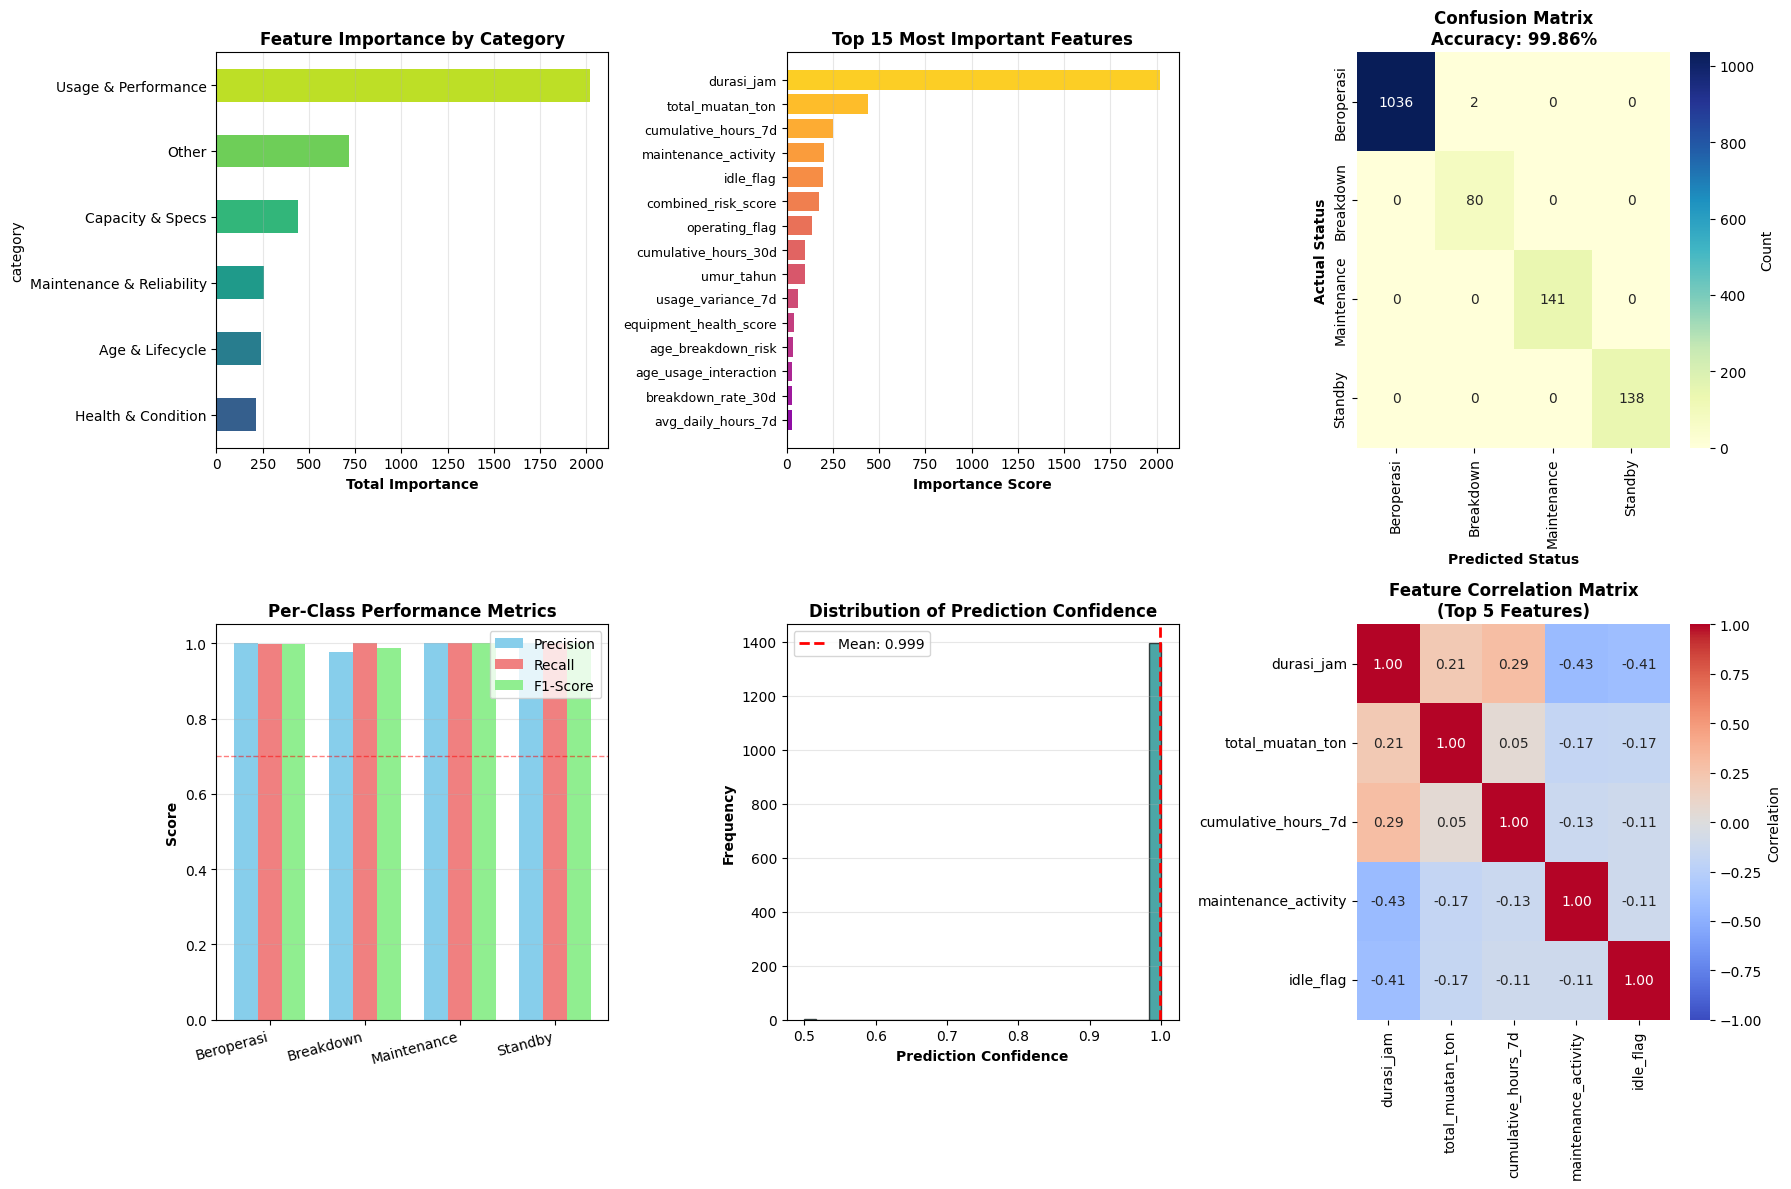

In [16]:
# ============================================================================
# 5. VISUALIZATIONS
# ============================================================================

print("\n" + "="*80)
print("5. GENERATING VISUALIZATIONS")
print("="*80)

# Create figure with multiple subplots
fig = plt.figure(figsize=(18, 12))

# 5.1 Feature Importance by Category (Bar Chart)
ax1 = plt.subplot(2, 3, 1)
category_importance_sorted = category_importance.sort_values('sum', ascending=True)
colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(category_importance_sorted)))
category_importance_sorted['sum'].plot(kind='barh', ax=ax1, color=colors)
ax1.set_xlabel('Total Importance', fontweight='bold')
ax1.set_title('Feature Importance by Category', fontweight='bold', fontsize=12)
ax1.grid(axis='x', alpha=0.3)

# 5.2 Top 15 Individual Features
ax2 = plt.subplot(2, 3, 2)
top_15_features = importance_df.head(15).sort_values('importance', ascending=True)
colors_features = plt.cm.plasma(np.linspace(0.3, 0.9, len(top_15_features)))
ax2.barh(range(len(top_15_features)), top_15_features['importance'], color=colors_features)
ax2.set_yticks(range(len(top_15_features)))
ax2.set_yticklabels(top_15_features['feature'], fontsize=9)
ax2.set_xlabel('Importance Score', fontweight='bold')
ax2.set_title('Top 15 Most Important Features', fontweight='bold', fontsize=12)
ax2.grid(axis='x', alpha=0.3)

# 5.3 Confusion Matrix Heatmap
ax3 = plt.subplot(2, 3, 3)
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', 
            xticklabels=labels, yticklabels=labels, 
            ax=ax3, cbar_kws={'label': 'Count'})
ax3.set_title(f'Confusion Matrix\nAccuracy: {accuracy:.2%}', fontweight='bold', fontsize=12)
ax3.set_ylabel('Actual Status', fontweight='bold')
ax3.set_xlabel('Predicted Status', fontweight='bold')

# 5.4 Per-Class Performance Comparison
ax4 = plt.subplot(2, 3, 4)
x_pos = np.arange(len(labels))
width = 0.25
ax4.bar(x_pos - width, precision_per_class, width, label='Precision', color='skyblue')
ax4.bar(x_pos, recall_per_class, width, label='Recall', color='lightcoral')
ax4.bar(x_pos + width, f1_per_class, width, label='F1-Score', color='lightgreen')
ax4.set_ylabel('Score', fontweight='bold')
ax4.set_title('Per-Class Performance Metrics', fontweight='bold', fontsize=12)
ax4.set_xticks(x_pos)
ax4.set_xticklabels(labels, rotation=15, ha='right')
ax4.legend()
ax4.grid(axis='y', alpha=0.3)
ax4.axhline(y=0.70, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Target: 0.70')

# 5.5 Prediction Confidence Distribution
ax5 = plt.subplot(2, 3, 5)
ax5.hist(y_test_proba_max, bins=30, color='teal', alpha=0.7, edgecolor='black')
ax5.axvline(y_test_proba_max.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {y_test_proba_max.mean():.3f}')
ax5.set_xlabel('Prediction Confidence', fontweight='bold')
ax5.set_ylabel('Frequency', fontweight='bold')
ax5.set_title('Distribution of Prediction Confidence', fontweight='bold', fontsize=12)
ax5.legend()
ax5.grid(axis='y', alpha=0.3)

# 5.6 Feature Correlation Heatmap (Top 5)
ax6 = plt.subplot(2, 3, 6)
sns.heatmap(top_features_corr, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, vmin=-1, vmax=1, ax=ax6, cbar_kws={'label': 'Correlation'})
ax6.set_title('Feature Correlation Matrix\n(Top 5 Features)', fontweight='bold', fontsize=12)

plt.tight_layout()

# Save comprehensive visualization
comprehensive_path = output_dir / 'port_operability_comprehensive_analysis.png'
plt.savefig(comprehensive_path, dpi=300, bbox_inches='tight')
print(f"\nComprehensive analysis plot saved: {comprehensive_path.relative_to(project_root)}")

try:
    mlflow.log_artifact(str(comprehensive_path))
    print("Artifact logged to MLflow")
except Exception as e:
    print(f"Warning: Could not log artifact to MLflow - {e}")

plt.show()

In [17]:
# ============================================================================
# 6. BUSINESS INSIGHTS & RECOMMENDATIONS
# ============================================================================

print("\n" + "="*80)
print("6. BUSINESS INSIGHTS & RECOMMENDATIONS")
print("="*80)

print("\nKEY FINDINGS:")

# Finding 1: Overall model performance
accuracy_status = "EXCELLENT" if accuracy > 0.85 else "GOOD" if accuracy > 0.75 else "NEEDS IMPROVEMENT"
print(f"\n1. Model Performance: {accuracy_status}")
print(f"   - Overall Accuracy: {accuracy:.2%}")
print(f"   - Macro F1-Score: {f1_macro:.3f}")
if accuracy > 0.75:
    print(f"   Model meets target KPI (>75% accuracy)")
    print(f"   Ready for production deployment consideration")
else:
    print(f"   Model below target KPI - requires improvement")

# Finding 2: Feature category importance
top_category = category_importance.index[0]
top_category_pct = (category_importance.iloc[0]['sum'] / importance_df['importance'].sum() * 100)
print(f"\n2. Critical Feature Category: {top_category}")
print(f"   - Contributes {top_category_pct:.1f}% of total importance")
print(f"   - Focus monitoring and data quality efforts here")

# Finding 3: Class-specific performance
best_class = labels[np.argmax(f1_per_class)]
worst_class = labels[np.argmin(f1_per_class)]
print(f"\n3. Class Performance Variation:")
print(f"   - Best performing: {best_class} (F1: {f1_per_class[np.argmax(f1_per_class)]:.3f})")
print(f"   - Needs attention: {worst_class} (F1: {f1_per_class[np.argmin(f1_per_class)]:.3f})")

# Finding 4: Prediction confidence
high_confidence_pct = (y_test_proba_max >= 0.70).sum() / len(y_test_proba_max) * 100
print(f"\n4. Prediction Confidence:")
print(f"   - {high_confidence_pct:.1f}% of predictions have >70% confidence")
print(f"   - Average confidence: {y_test_proba_max.mean():.2%}")

# Finding 5: Top features
print(f"\n5. Most Critical Features (Top 3):")
for i, (_, row) in enumerate(importance_df.head(3).iterrows(), 1):
    print(f"   {i}. {row['feature']} (Importance: {row['importance']:.1f})")

print("\n" + "="*80)
print("ACTIONABLE RECOMMENDATIONS:")
print("="*80)

print("\n1. OPERATIONAL IMPROVEMENTS:")
print("   - Monitor top 5 features closely for data quality and anomalies")
print(f"   - Focus maintenance efforts on {top_category.lower()} factors")
print("   - Implement real-time monitoring dashboard for prediction confidence")

print("\n2. MODEL DEPLOYMENT:")
if accuracy > 0.75:
    print("   - Model ready for pilot deployment in port operations")
    print("   - Set confidence threshold at 70% for automatic decisions")
    print("   - Route low-confidence predictions to human review")
else:
    print("   - Improve model performance before deployment")
    print("   - Consider collecting more training data")
    print("   - Explore feature engineering opportunities")

print("\n3. DATA COLLECTION:")
print(f"   - Prioritize data quality for {top_category.lower()} features")
print("   - Consider adding more features related to maintenance history")
print("   - Ensure consistent data capture across all port equipment")

print("\n4. PERFORMANCE MONITORING:")
print("   - Track prediction accuracy by equipment type")
print("   - Monitor drift in feature distributions over time")
print("   - Set up alerts for prediction confidence drops")
print("   - Regular model retraining (recommended: quarterly)")

print("\n5. BUSINESS VALUE:")
print("   - Proactive maintenance scheduling based on status predictions")
print("   - Optimized resource allocation for port operations")
print("   - Reduced downtime through early status detection")
print("   - Better equipment lifecycle management")

# ============================================================================
# FINAL SUMMARY
# ============================================================================

print("\n" + "="*80)
print("ANALYSIS COMPLETE - PORT OPERABILITY FORECAST")
print("="*80)

print(f"\nFeature importance analysis completed")
print(f"Model performance deep dive completed")
print(f"Confusion matrix analysis completed")
print(f"Feature interaction analysis completed")
print(f"Comprehensive visualizations generated")
print(f"Business insights and recommendations provided")

print(f"\nGenerated Artifacts:")
print(f"  - Comprehensive analysis plot: {comprehensive_path.relative_to(project_root)}")
print(f"  - Feature importance CSV: reports/port_operability_feature_importance.csv")
print(f"  - Confusion matrix plot: reports/figures/port_operability_confusion_matrix.png")

print(f"\nModel Status: {accuracy_status}")
print(f"Overall Accuracy: {accuracy:.2%} | Macro F1: {f1_macro:.3f}")

print("\n" + "="*80)


6. BUSINESS INSIGHTS & RECOMMENDATIONS

KEY FINDINGS:

1. Model Performance: EXCELLENT
   - Overall Accuracy: 99.86%
   - Macro F1-Score: 0.997
   Model meets target KPI (>75% accuracy)
   Ready for production deployment consideration

2. Critical Feature Category: Usage & Performance
   - Contributes 51.9% of total importance
   - Focus monitoring and data quality efforts here

3. Class Performance Variation:
   - Best performing: Maintenance (F1: 1.000)
   - Needs attention: Breakdown (F1: 0.988)

4. Prediction Confidence:
   - 99.9% of predictions have >70% confidence
   - Average confidence: 99.93%

5. Most Critical Features (Top 3):
   1. durasi_jam (Importance: 2018.0)
   2. total_muatan_ton (Importance: 441.0)
   3. cumulative_hours_7d (Importance: 248.0)

ACTIONABLE RECOMMENDATIONS:

1. OPERATIONAL IMPROVEMENTS:
   - Monitor top 5 features closely for data quality and anomalies
   - Focus maintenance efforts on usage & performance factors
   - Implement real-time monitoring da